# Sentinel Ranking Maps

This notebook visualizes the top 10 sentinel nodes for each ranking metric and several network centrality metrics using property coordinates.

In [77]:
from pathlib import Path

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120


In [78]:

DATA_ROOT = Path("..")

RANK_TABLE_PATH = DATA_ROOT / "notebook" / "sentinel_rank_table.csv"
PROPERTY_PATH = DATA_ROOT / "params" / "2024_prop_dat.csv"
REGION_SHAPE_PATH = DATA_ROOT / "params" / "regional-council-2025-clipped.shp"
SEED_DATA_PATH = DATA_ROOT / "data" / "data_y_real.csv"

TOP_FRACTION = 0.01

rank_table = pd.read_csv(RANK_TABLE_PATH)

properties = pd.read_csv(PROPERTY_PATH)
properties = properties.rename(
    columns={
        "GPS_CENTRE_LATITUDE": "longitude",
        "GPS_CENTRE_LONGITUDE": "latitude",
    }
)
properties_coords = (
    properties[["PROPERTY_ID", "latitude", "longitude"]]
    .dropna(subset=["latitude", "longitude"])
    .drop_duplicates(subset=["PROPERTY_ID"])
)

seed_ids = pd.read_csv(SEED_DATA_PATH, usecols=["seed"])["seed"]
seed_ids = pd.to_numeric(seed_ids, errors="coerce").dropna().astype(int)
seed_coords = properties_coords[properties_coords["PROPERTY_ID"].isin(seed_ids)].copy()
seed_points = gpd.GeoDataFrame(
    seed_coords,
    geometry=gpd.points_from_xy(seed_coords["longitude"], seed_coords["latitude"]),
    crs="EPSG:4326",
)

nz_regions = gpd.read_file(REGION_SHAPE_PATH)
if nz_regions.crs is None:
    nz_regions = nz_regions.set_crs(epsg=4326, allow_override=True)
elif getattr(nz_regions.crs, "to_epsg", lambda: None)() != 4326:
    nz_regions = nz_regions.to_crs(epsg=4326)

rank_summary = (
    rank_table
    .rename(columns={"sent": "PROPERTY_ID"})
    .drop_duplicates(subset=["PROPERTY_ID"])
    .merge(properties_coords, on="PROPERTY_ID", how="left")
)
rank_summary[["R_F", "R_I", "R_T", "d", "close", "ev", "w", "i_w", "o_w"]] = rank_summary[["R_F", "R_I", "R_T", "d", "close", "ev", "w", "i_w", "o_w"]].apply(pd.to_numeric, errors="coerce")

centrality_df = rank_summary[["PROPERTY_ID", "latitude", "longitude", "d", "close", "ev", "w", "i_w", "o_w"]].copy()

ranking_top_n = max(1, int(np.ceil(len(rank_summary) * TOP_FRACTION)))
centrality_top_n = max(1, int(np.ceil(len(centrality_df) * TOP_FRACTION)))

lon_bounds = (166.0, 179.0)
lat_bounds = (-47.5, -33.5)

print(
    f"Working with {len(rank_summary)} sentinel nodes." 
)
print(
    f"Top {ranking_top_n} (~{TOP_FRACTION*100:.1f}%) per ranking metric and top {centrality_top_n} per centrality metric will be shown."
)



Working with 1503 sentinel nodes.
Top 16 (~1.0%) per ranking metric and top 16 per centrality metric will be shown.


In [79]:

ranking_specs = {
    "R_F": {
        "rank_col": "R_F",
        "value_col": "R_F",
        "title": "Top 1% Sentinels by R_F",
        "cmap": "viridis_r",
    },
    "R_I": {
        "rank_col": "R_I",
        "value_col": "R_I",
        "title": "Top 1% Sentinels by R_I",
        "cmap": "viridis_r",
    },
    "R_T": {
        "rank_col": "R_T",
        "value_col": "R_T",
        "title": "Top 1% Sentinels by R_T",
        "cmap": "viridis_r",
    },
}

rank_top_tables = {}
for key, spec in ranking_specs.items():
    table = (
        rank_summary
        .dropna(subset=[spec["rank_col"], "latitude", "longitude"])
        .sort_values(spec["rank_col"], ascending=True)
        .head(ranking_top_n)
        .copy()
    )
    rank_top_tables[key] = table

centrality_specs = {
    "d": {
        "metric_col": "d",
        "title": "Top 1% Nodes by Degree",
        "cmap": "plasma",
    },
    "close": {
        "metric_col": "close",
        "title": "Top 1% Nodes by Closeness",
        "cmap": "magma",
    },
    "ev": {
        "metric_col": "ev",
        "title": "Top 1% Nodes by Eigenvector",
        "cmap": "magma",
    },
    "w": {
        "metric_col": "w",
        "title": "Top 1% Nodes by Total Weight",
        "cmap": "inferno",
    },
}

centrality_top_tables = {}
for key, spec in centrality_specs.items():
    table = (
        centrality_df
        .dropna(subset=[spec["metric_col"], "latitude", "longitude"])
        .sort_values(spec["metric_col"], ascending=False)
        .head(centrality_top_n)
        .copy()
    )
    centrality_top_tables[key] = table



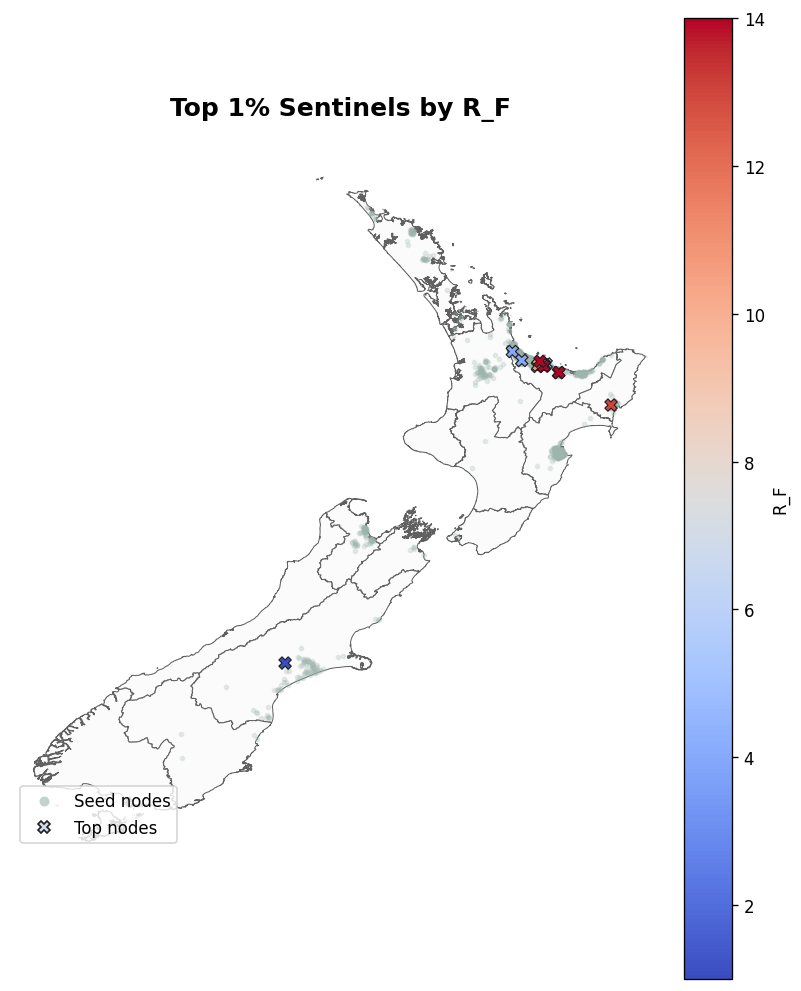

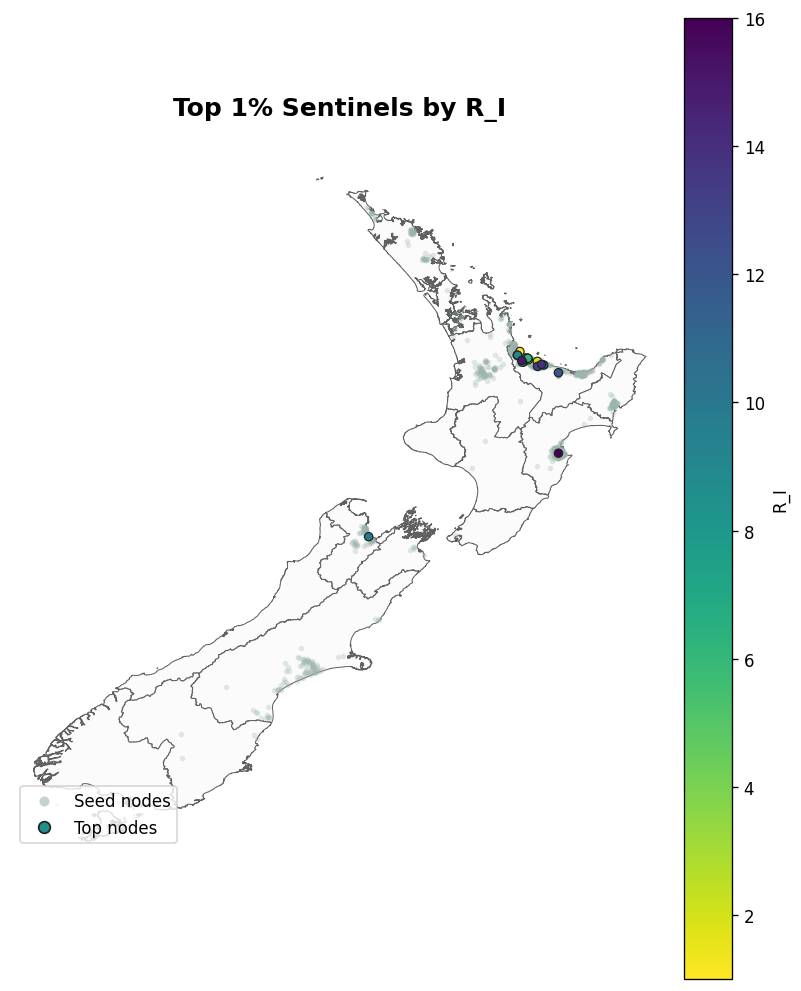

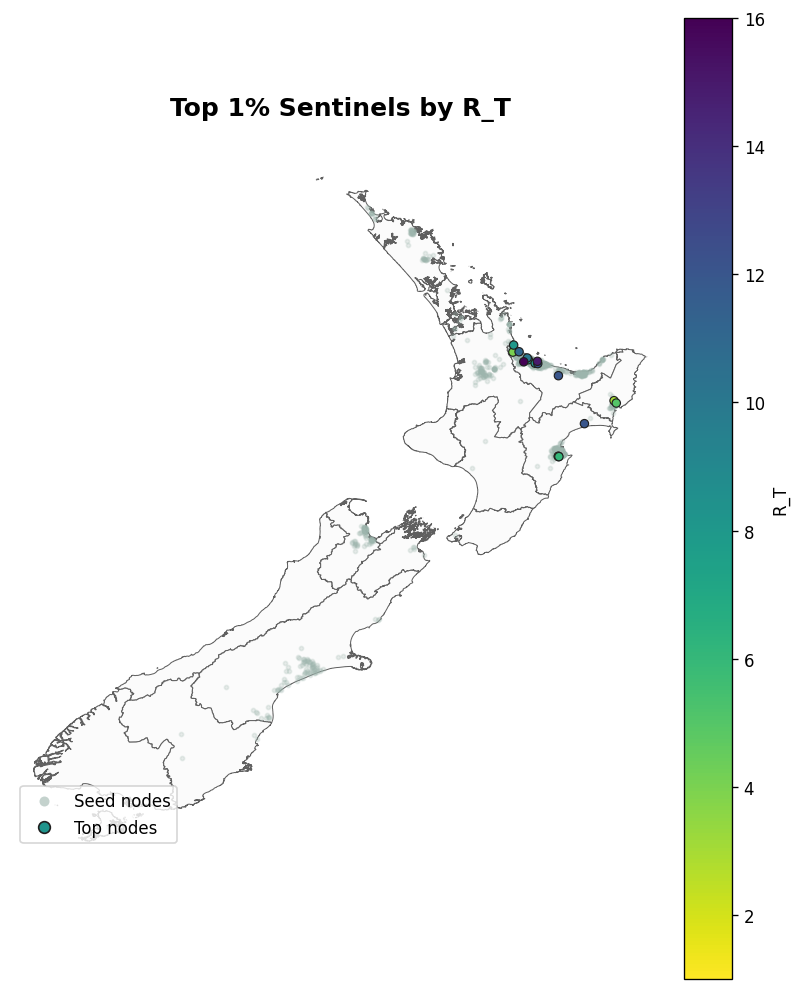

In [ ]:

for key, spec in ranking_specs.items():
    marker_style = "o"
    marker_size = 25
    cmap = spec.get("cmap", "viridis_r")
    plot_top_nodes(
        rank_top_tables[key],
        title=spec["title"],
        value_col=spec["rank_col"],
        cmap=cmap,
        annotate=True,
        base_points=seed_points,
        base_map=nz_regions,
        marker_size=marker_size,
        marker_style=marker_style,
    )



In [81]:
def plot_top_nodes(
    df,
    title,
    value_col,
    cmap="viridis",
    annotate=True,
    base_points=None,
    base_map=None,
    marker_size=25,
    marker_style="o",
):
    """Scatter top nodes on a stylized New Zealand basemap."""
    if df.empty:
        print(f"No data to plot for {title}.")
        return

    def as_geodf(data):
        if data is None:
            return None
        if isinstance(data, gpd.GeoDataFrame):
            return data
        required_cols = {"longitude", "latitude"}
        missing = required_cols - set(data.columns)
        if missing:
            raise ValueError(f"Missing coordinate columns: {missing}")
        return gpd.GeoDataFrame(
            data.copy(),
            geometry=gpd.points_from_xy(data["longitude"], data["latitude"]),
            crs="EPSG:4326",
        )

    point_gdf = as_geodf(df)
    background_gdf = as_geodf(base_points)

    fig, ax = plt.subplots(figsize=(8.5, 13))
    fig.patch.set_facecolor("white")

    if base_map is not None:
        base_map.plot(ax=ax, color="#fbfbfb", edgecolor="#606060", linewidth=0.6, zorder=0)

    if background_gdf is not None and not background_gdf.empty:
        background_gdf.plot(ax=ax, color="#9db5ad", alpha=0.22, markersize=6, zorder=1)

    values = point_gdf[value_col]
    cmap_obj = plt.get_cmap(cmap)
    norm = plt.Normalize(vmin=float(values.min()), vmax=float(values.max()))
    colors = cmap_obj(norm(values))
    ax.scatter(
        point_gdf.geometry.x,
        point_gdf.geometry.y,
        s=marker_size,
        c=colors,
        edgecolor="#1f1f1f",
        linewidth=0.7,
        marker=marker_style,
        zorder=2,
    )

    ax.set_xlim(lon_bounds)
    ax.set_ylim(lat_bounds)
    ax.set_aspect("equal", adjustable="box")
    ax.set_title(title, fontsize=15, fontweight="bold", pad=18)
    ax.set_axis_off()

    sm = cm.ScalarMappable(norm=norm, cmap=cmap_obj)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, shrink=0.8, pad=0.02)
    cbar.set_label(value_col)

    legend_handles = []
    if background_gdf is not None and not background_gdf.empty:
        legend_handles.append(
            Line2D([], [], marker="o", linestyle="", markersize=6, markerfacecolor="#9db5ad", markeredgewidth=0, alpha=0.6, label="Seed nodes")
        )
    legend_handles.append(
        Line2D([], [], marker=marker_style, linestyle="", markersize=7, markerfacecolor=cmap_obj(norm(values.mean())), markeredgecolor="#1f1f1f", label="Top nodes")
    )
    ax.legend(handles=legend_handles, loc="lower left", frameon=True)

    plt.show()



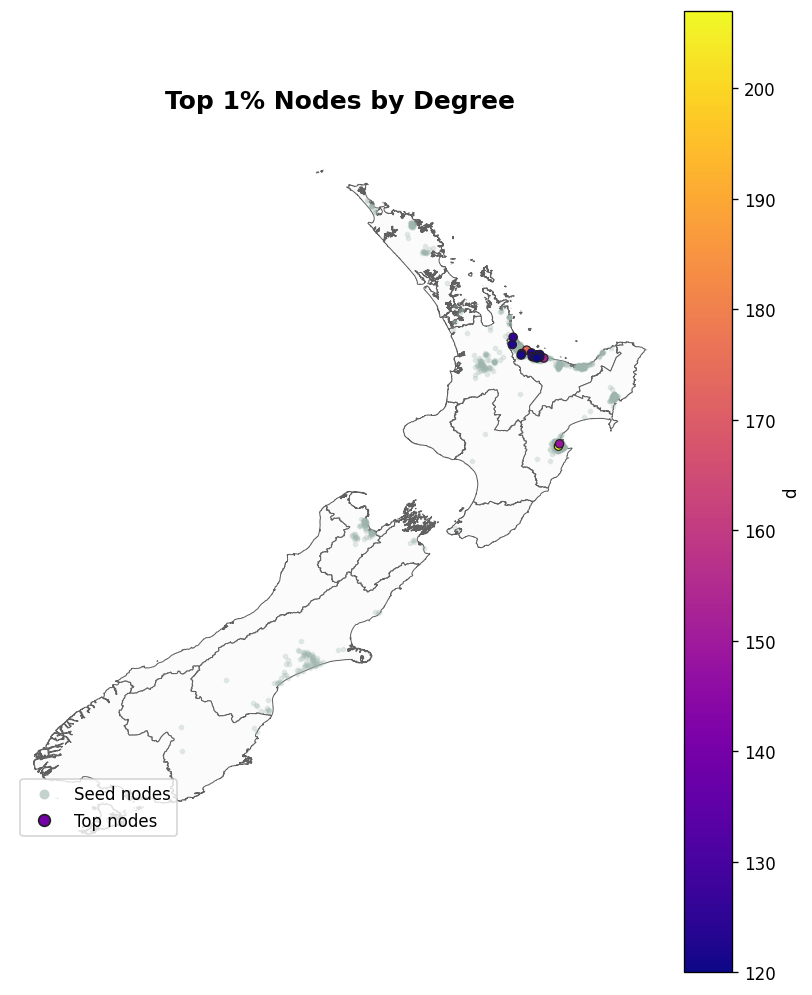

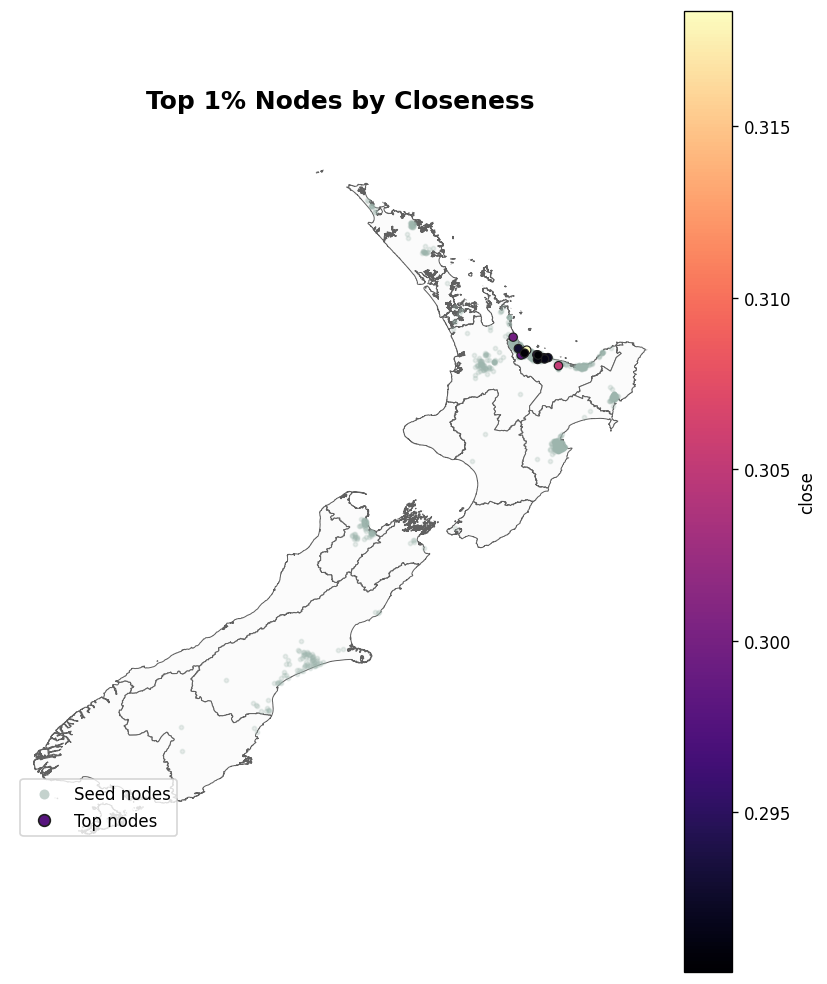

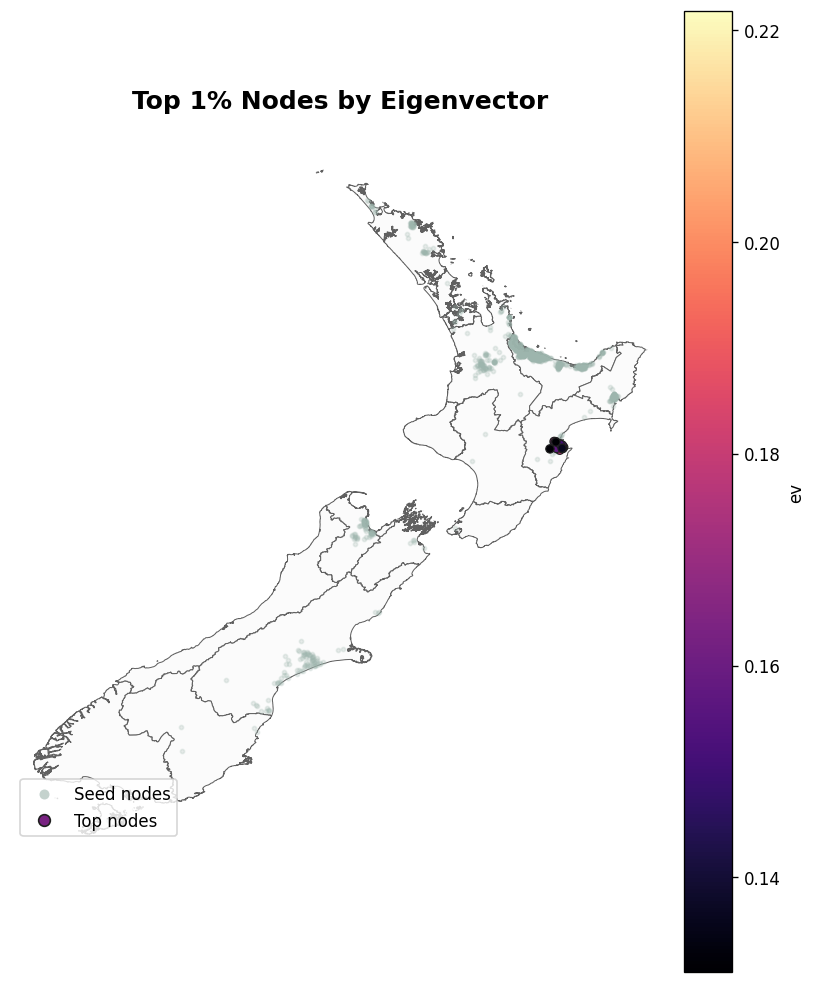

In [82]:

for key, spec in centrality_specs.items():
    plot_top_nodes(
        centrality_top_tables[key],
        title=spec["title"],
        value_col=spec["metric_col"],
        cmap=spec.get("cmap", "plasma"),
        annotate=True,
        base_points=seed_points,
        base_map=nz_regions,
        marker_size=25,
    )

